In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from dataHandler.dataset import MHDProjDataset,LogNormalTransform
import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
MODEL_ID='VAE_1.3'

SOURCE_DIR='/mnt/home/dheurtel/ceph/00_exploration_data/density/b_proj'

SAMPLE_FOLDER='/mnt/home/dheurtel/ceph/20_samples/ddpm_initial/'  #For periodic samples
CKPT_FOLDER='/mnt/home/dheurtel/ceph/10_checkpoints/VAE_FID/' #For checkpoints and losses



SIZE=256
SAMPLE_BATCH_SIZE=8
BATCH_SIZE=64
RESULT_SAMPLE_SIZE=256


SAMPLE_STEP_EPOCH=100

NUM_EPOCHS=500

LR=1e-3

BETA=1

In [3]:
os.listdir(CKPT_FOLDER)

['VAE_1.0', 'VAE_1.1']

In [30]:
1%1

0

In [29]:
for _,batch in enumerate(dataloader):
    print(torch.min(batch), torch.max(batch))

tensor(-4.2385) tensor(4.5796)
tensor(-4.6850) tensor(5.0115)
tensor(-4.2552) tensor(5.2576)
tensor(-4.1366) tensor(5.1914)
tensor(-4.0492) tensor(5.1723)
tensor(-4.6356) tensor(5.3108)
tensor(-4.9769) tensor(4.7624)
tensor(-4.5407) tensor(4.8757)
tensor(-4.0112) tensor(5.4101)
tensor(-4.2778) tensor(5.1377)
tensor(-5.2713) tensor(5.5089)
tensor(-4.5961) tensor(4.5321)
tensor(-4.4160) tensor(4.9630)
tensor(-4.0753) tensor(5.1905)
tensor(-4.0108) tensor(5.0218)
tensor(-3.8000) tensor(5.3897)


In [5]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
dataset=MHDProjDataset(SOURCE_DIR,transforms=LogNormalTransform(),random_rotate=True,sorted=False)

In [7]:
dataloader=torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [8]:
class NormalizedConvolution(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding='same', padding_mode='circular', activation=None, normalize=True):
        super(NormalizedConvolution, self).__init__()
        self.ln = nn.BatchNorm2d(in_c)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding,padding_mode=padding_mode)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        return out
    
def TinyBlock(size, in_c, out_c):
    return nn.Sequential(NormalizedConvolution((in_c, size, size), in_c, out_c), 
                         NormalizedConvolution((out_c, size, size), out_c, out_c), 
                         NormalizedConvolution((out_c, size, size), out_c, out_c))

def TinyUp(size, in_c):
    return nn.Sequential(NormalizedConvolution((in_c, size, size), in_c, in_c//2), 
                         NormalizedConvolution((in_c//2, size, size), in_c//2, in_c//4), 
                         NormalizedConvolution((in_c//4, size, size), in_c//4, in_c//4))

In [9]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=512, z_dim=256):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            TinyBlock(SIZE, image_channels, 8),
            nn.Conv2d(8, 8, 4, 4, 1),
            TinyBlock(SIZE//4,8,32),
            nn.Conv2d(32, 32, 4, 4, 1),
            TinyBlock(SIZE//16, 32, 128),
            nn.Conv2d(128,128, 4, 4, 1),
            TinyBlock(SIZE//64, 128, 512),
            nn.Conv2d(512, 512, 4, 4, 1),
            nn.Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.fc=nn.Linear(h_dim,h_dim)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 4, 0),
            TinyUp(SIZE//64, 512),
            nn.ConvTranspose2d(128, 128, 4, 4, 0),
            TinyUp(SIZE//16, 128),
            nn.ConvTranspose2d(32, 32, 4, 4, 0),
            TinyUp(SIZE//4, 32),
            nn.ConvTranspose2d(8, 8, 4, 4, 0),
            TinyBlock(SIZE, 8, 4),
            nn.Conv2d(4, image_channels,1, 1, 'same')
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    
    # def forward(self, x):
    #     h = self.encoder(x)
    #     #z = self.fc1(self.fc3(h))
    #     z=self.fc(h).unsqueeze(-1).unsqueeze(-1)
    #     return self.decoder(z)
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z).unsqueeze(-1).unsqueeze(-1)
        return self.decoder(z), mu, logvar

In [10]:
def loss_fn(recon_x,x,mu,logvar):
    MSE=F.mse_loss(recon_x,x)
    KLD= -0.5*torch.mean(1+logvar-mu.pow(2)-logvar.exp())
    return MSE+BETA*KLD,MSE,KLD

# def loss_fn(recon_x,x):
#     MSE=F.l1_loss(recon_x,x)
#     return MSE

In [11]:
model = VAE(image_channels=1).to(device)

In [12]:
#ckpt = torch.load(os.path.join(CKPT_FOLDER, MODEL_ID, 'ckpt.pt'))
#model.load_state_dict(ckpt['vae'])

In [13]:
epochs=200

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 

scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=160,gamma=0.9)

In [15]:
progress_bar = tqdm.tqdm(total=epochs)

for epoch in range(epochs):
    
    model.train()
    avg_loss,avg_mse,avg_kld=0,0,0
    tot_step=0

    for step,images in enumerate(dataloader):
        images=images.unsqueeze(1).to(device)
        recon_images, mu, logvar = model(images)
        loss, mse, kld = loss_fn(recon_images, images, mu, logvar)

        #recon_images=model(images)
        #loss=loss_fn(recon_images,images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        

        #logs = {"_loss": loss.detach().item() }
        #progress_bar.set_postfix(**logs)
        avg_loss+=loss
        avg_kld+=kld
        avg_mse+=mse
        #scheduler.step()
        tot_step+=1
    avg_loss=avg_loss/tot_step
    avg_kld=avg_kld/tot_step
    avg_mse=avg_mse/tot_step

    progress_bar.update(1)
    logs = {"_loss": loss.detach().item(), "mse" : mse.detach().item(), "kld": kld.detach().item() }
    progress_bar.set_postfix(**logs)
    
progress_bar.close()

100%|██████████| 200/200 [11:50<00:00,  3.55s/it, _loss=0.798, kld=0.0525, mse=0.745] 


In [20]:
recons_x=model(dataset[1].unsqueeze(0).unsqueeze(0).to(device))

In [28]:
_,batch=next(enumerate(dataloader))

In [21]:
recons_x[0].shape

torch.Size([1, 1, 256, 256])

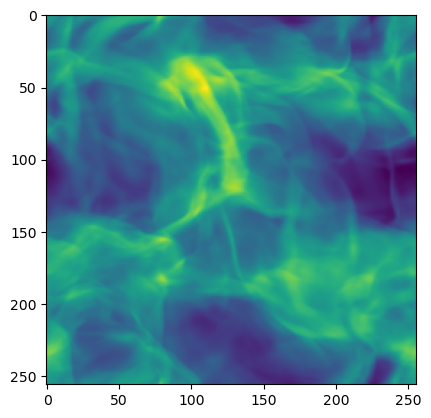

In [22]:
plt.imshow(dataset[1])

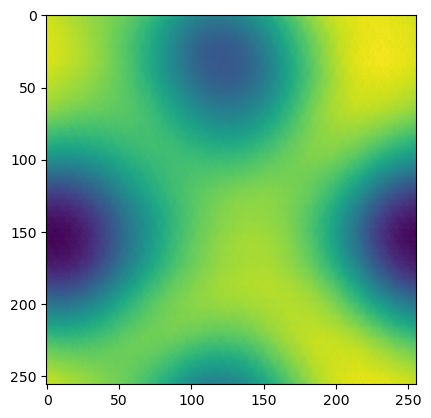

In [23]:
plt.imshow(recons_x[0][0][0].cpu().detach())

In [22]:
ckpt= {'vae': model.state_dict()}
torch.save(ckpt,os.path.join(CKPT_FOLDER,MODEL_ID,'ckpt.pt'))

RuntimeError: Parent directory /mnt/home/dheurtel/ceph/10_checkpoints/VAE_FID/VAE_1.1 does not exist.

In [23]:
os.mkdir(os.path.join(CKPT_FOLDER,MODEL_ID))